In [ ]:
from google.colab import files
uploaded = files.upload()

Saving augmented_dataset-20250317T074401Z-001.zip to augmented_dataset-20250317T074401Z-001.zip


In [2]:
import zipfile
import os

# Replace the filename with your actual uploaded file name
zip_path = "augmented_dataset_cleaned.zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(".")

# Verify extracted folders
os.listdir("/content")

['.config',
 'masks',
 'masks_clean',
 'images',
 'augmented_dataset_cleaned.zip',
 'sample_data']

In [1]:
#delete augmented_dataset folder fully
#import shutil
#shutil.rmtree('augmented_dataset')

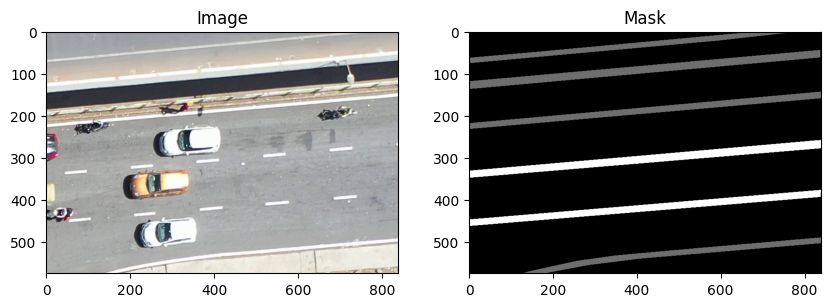

In [3]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Set your path
image_path = 'images/valid/12_11.jpg'
mask_path = 'masks/valid/12_11.png'

# Load
image = Image.open(image_path).convert('RGB')
mask = Image.open(mask_path).convert('L')

# Display
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Image")
plt.imshow(image)
plt.subplot(1,2,2)
plt.title("Mask")
plt.imshow(mask, cmap='gray')
plt.show()

#### FInding unique classes

Dominant Colors (excluding background):
Class 1: RGB(np.int64(254), np.int64(254), np.int64(254)) - 33756473 pixels
Class 2: RGB(np.int64(109), np.int64(74), np.int64(38)) - 15046003 pixels
Class 3: RGB(np.int64(134), np.int64(205), np.int64(233)) - 9325060 pixels
Class 4: RGB(np.int64(127), np.int64(127), np.int64(0)) - 3028656 pixels
Class 5: RGB(np.int64(240), np.int64(111), np.int64(9)) - 3049347 pixels
Class 6: RGB(np.int64(20), np.int64(18), np.int64(13)) - 702264 pixels


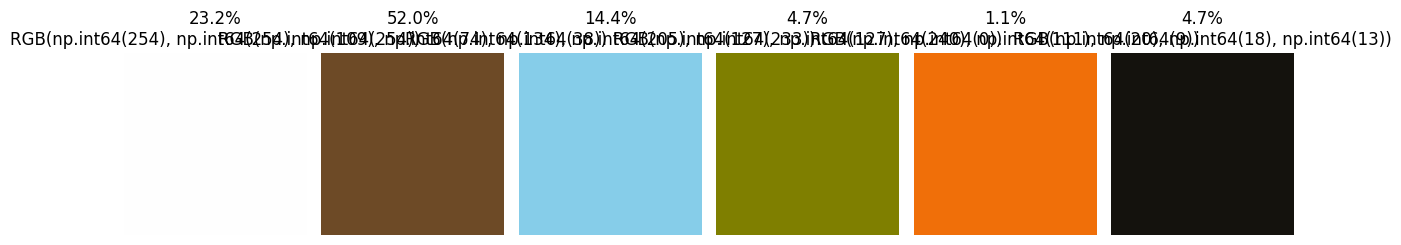

In [4]:
import numpy as np
from sklearn.cluster import KMeans
from collections import Counter
import matplotlib.pyplot as plt
from PIL import Image
import os

def get_dominant_colors(mask_folder, n_colors=6, sample_size=1000):
    """
    Extract dominant colors from masks using k-means clustering
    Returns:
        - dominant_colors: List of (R,G,B) tuples
        - color_counts: Frequency of each dominant color
    """
    all_pixels = []

    # Sample masks to speed up processing
    mask_files = [f for f in os.listdir(mask_folder) if f.endswith('.png')]
    sample_files = np.random.choice(mask_files, min(sample_size, len(mask_files)), replace=False)

    for mask_file in sample_files:
        mask = np.array(Image.open(os.path.join(mask_folder, mask_file)))
        pixels = mask.reshape(-1, 3)

        # Exclude pure black (background)
        non_bg_pixels = pixels[~np.all(pixels == [0, 0, 0], axis=1)]
        if len(non_bg_pixels) > 0:
            all_pixels.extend(non_bg_pixels)

    # Convert to numpy array
    all_pixels = np.array(all_pixels)

    # Perform k-means clustering
    kmeans = KMeans(n_clusters=n_colors, random_state=42)
    kmeans.fit(all_pixels)

    # Get dominant colors and their frequencies
    dominant_colors = kmeans.cluster_centers_.astype(int)
    color_counts = Counter(kmeans.labels_)

    # Sort by frequency (most common first)
    sorted_indices = np.argsort([-color_counts[i] for i in range(n_colors)])
    dominant_colors = dominant_colors[sorted_indices]

    return dominant_colors, color_counts

def visualize_dominant_colors(dominant_colors, color_counts):
    """Visualize the dominant colors with their frequencies"""
    plt.figure(figsize=(12, 3))
    total_pixels = sum(color_counts.values())

    for i, (color, count) in enumerate(zip(dominant_colors, color_counts.values())):
        plt.subplot(1, len(dominant_colors), i+1)
        plt.imshow([[color/255]])
        plt.axis('off')
        plt.title(f"{count/total_pixels:.1%}\nRGB{tuple(color)}")

    plt.tight_layout()
    plt.show()

# Usage
mask_folder = "augmented_dataset/masks/train"
dominant_colors, color_counts = get_dominant_colors(mask_folder, n_colors=6)
print("Dominant Colors (excluding background):")
for i, color in enumerate(dominant_colors):
    print(f"Class {i+1}: RGB{tuple(color)} - {color_counts[i]} pixels")

visualize_dominant_colors(dominant_colors, color_counts)

#### Unique classes

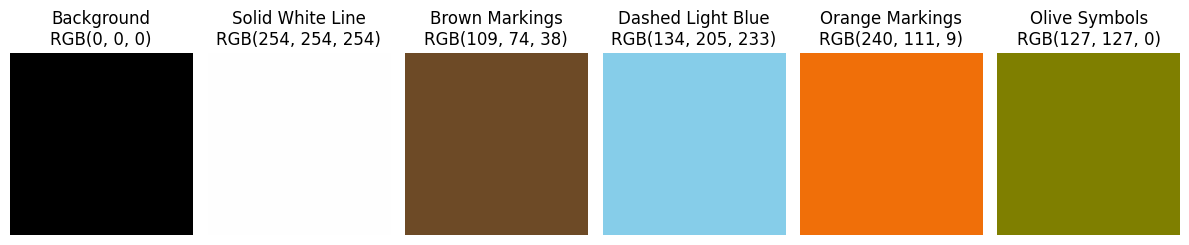

In [5]:
# Based on your results - convert np.int64 to regular integers
TARGET_CLASS_COLORS = [
    (0, 0, 0),           # 0: Background (pure black)
    (254, 254, 254),     # 1: Solid White Line (almost pure white)
    (109, 74, 38),       # 2: Brown Markings (e.g., yellow curbs that appear brownish)
    (134, 205, 233),     # 3: Light Blue (dashed lines)
    (240, 111, 9),       # 4: Orange (centerlines/special markings)
    (127, 127, 0),       # 5: Olive (symbols/special markings)
    # Note: The last color (20,19,13) is very close to black - likely artifacts
]

CLASS_NAMES = [
    "Background",
    "Solid White Line",
    "Brown Markings",
    "Dashed Light Blue",
    "Orange Markings",
    "Olive Symbols"
]


# Create a figure and axes
fig, ax = plt.subplots(1, len(TARGET_CLASS_COLORS), figsize=(12, 3))

# Plot each class color
for i, color in enumerate(TARGET_CLASS_COLORS):
    ax[i].imshow([[color]])  # Display the color
    ax[i].axis('off')  # Remove axes ticks and labels
    ax[i].set_title(f"{CLASS_NAMES[i]}\nRGB{color}")  # Set title with class name and RGB

plt.tight_layout()  # Adjust spacing between subplots
plt.show()  # Display the figure

#### Quantization

In [6]:
# Define class-specific tolerances (experiment with these values)
CLASS_TOLERANCES = {
    0: 5,    # Background - keep strict
    1: 10,   # White - allow slight variations
    2: 20,   # Brown - more tolerance for color variations
    3: 15,   # Light blue
    4: 15,   # Orange
    5: 20    # Olive
}

In [7]:
def quantize_colors(mask_array, target_colors, tolerances):
    """
    Enhanced quantization with class-specific tolerances
    Returns:
        quantized: (H,W) array where each pixel contains class index
        confidence: (H,W) array with 1.0 = exact match, <1.0 = partial match
    """
    h, w = mask_array.shape[:2]
    quantized = np.zeros((h, w), dtype=np.uint8)
    confidence = np.zeros((h, w), dtype=np.float32)

    # Process classes in reverse order (so more specific classes can override background)
    for class_idx in sorted(range(len(target_colors)), key=lambda x: -x):
        target_color = np.array(target_colors[class_idx])
        distance = np.sqrt(np.sum((mask_array - target_color)**2, axis=2))
        tolerance = tolerances[class_idx]

        # Create mask for pixels that should be assigned to this class:
        # 1. Within tolerance AND
        # 2. Either unassigned OR closer than previous assignment
        current_class_mask = (distance < tolerance)
        unassigned_or_better = np.zeros_like(current_class_mask)

        # For each pixel, check if it's unassigned OR if this class is a better match
        for i in range(h):
            for j in range(w):
                if quantized[i,j] == 0:  # Unassigned
                    unassigned_or_better[i,j] = True
                else:
                    # Compare with current assignment
                    current_dist = np.sqrt(np.sum((mask_array[i,j] - target_colors[quantized[i,j]])**2))
                    unassigned_or_better[i,j] = (distance[i,j] < current_dist)

        assign_mask = current_class_mask & unassigned_or_better

        # Update the quantization
        quantized[assign_mask] = class_idx
        confidence[assign_mask] = 1 - (distance[assign_mask] / tolerance)

    return quantized, confidence

In [8]:
def quantize_colors(mask_array, target_colors, tolerances):
    """
    Vectorized version of the color quantizer
    """
    h, w = mask_array.shape[:2]
    quantized = np.zeros((h, w), dtype=np.uint8)
    confidence = np.zeros((h, w), dtype=np.float32)

    # Pre-compute all distances
    distances = np.zeros((h, w, len(target_colors)))
    for i, color in enumerate(target_colors):
        distances[:,:,i] = np.sqrt(np.sum((mask_array - color)**2, axis=2))

    # Find best class for each pixel
    for class_idx in sorted(range(len(target_colors)), key=lambda x: -x):
        tolerance = tolerances[class_idx]
        class_mask = (distances[:,:,class_idx] < tolerance)

        # Pixels that are either:
        # 1. Unassigned (quantized == 0) OR
        # 2. This class is closer than current assignment
        better_mask = (quantized == 0) | (distances[:,:,class_idx] < distances[
            np.arange(h)[:,None], np.arange(w), quantized])

        assign_mask = class_mask & better_mask

        quantized[assign_mask] = class_idx
        confidence[assign_mask] = 1 - (distances[:,:,class_idx][assign_mask] / tolerance)

    return quantized, confidence

#### postprocessing for clean mask

In [9]:
from skimage import morphology
from skimage.morphology import remove_small_objects, binary_opening, disk

In [10]:
def clean_quantized_mask(quantized, min_size=100):
    cleaned = quantized.copy()

    # Process each class (except background)
    for class_idx in range(1, len(TARGET_CLASS_COLORS)):
        # Create binary mask for this class
        class_mask = (quantized == class_idx)

        # Remove small objects
        cleaned_class = remove_small_objects(class_mask, min_size=min_size)

        # Smooth edges
        cleaned_class = binary_opening(cleaned_class, footprint=disk(1))

        # Update cleaned mask
        cleaned[class_mask] = 0  # Remove original
        cleaned[cleaned_class] = class_idx  # Add cleaned

    return cleaned


Verifying: h_13_55_96.png


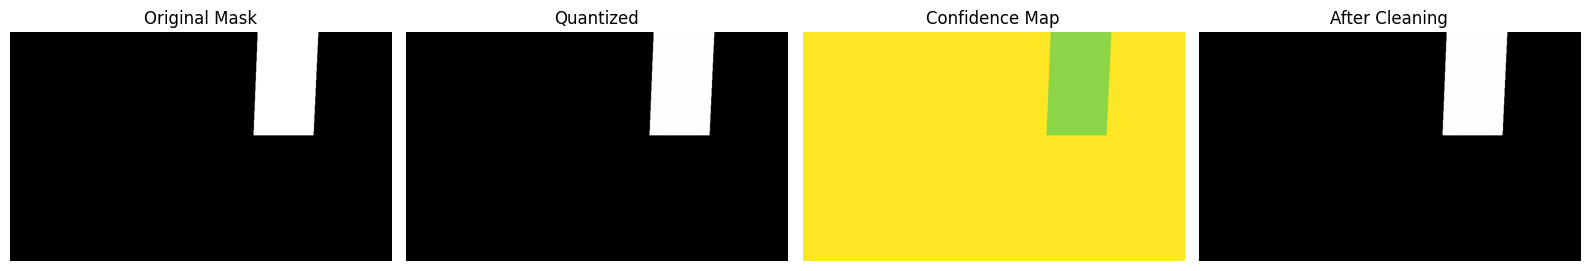


Verifying: v_8_56.png


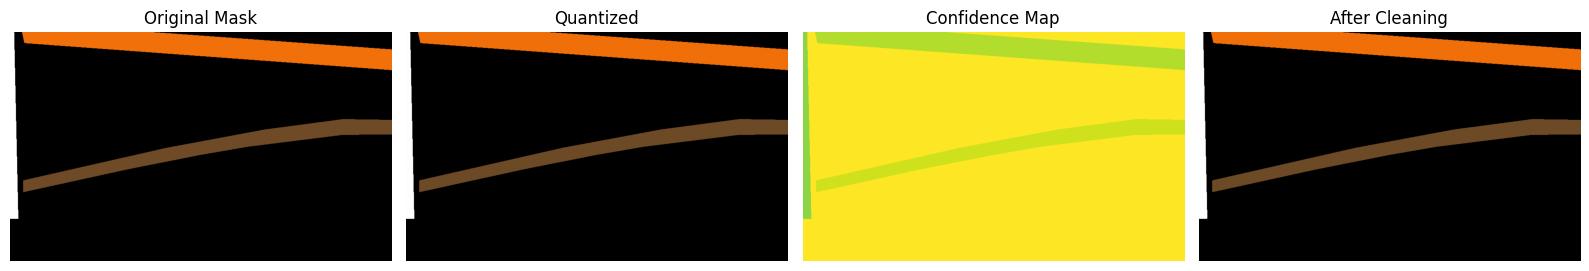


Verifying: h_13_55_69.png


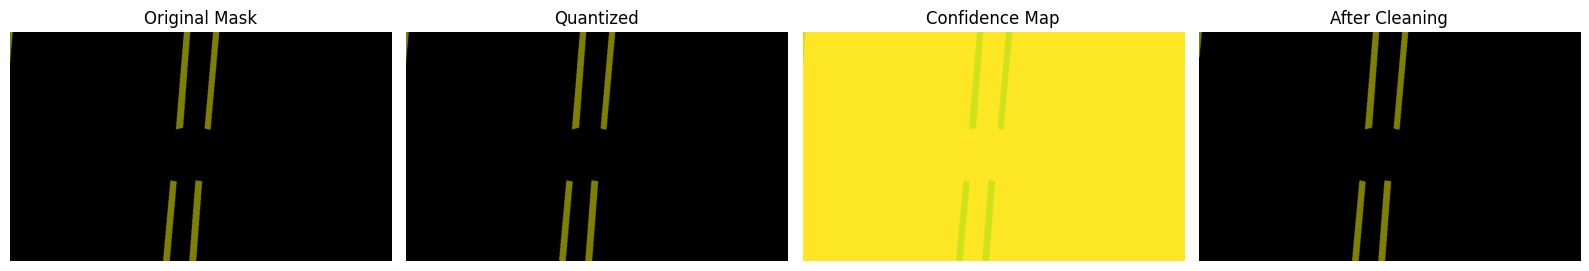

In [11]:
def verify_with_samples(mask_folder, num_samples=3):
    mask_files = [f for f in os.listdir(mask_folder) if f.endswith('.png')]
    samples = np.random.choice(mask_files, min(num_samples, len(mask_files)), replace=False)

    for mask_file in samples:
        print(f"\nVerifying: {mask_file}")
        original = np.array(Image.open(os.path.join(mask_folder, mask_file)))

        try:
            quantized, confidence = quantize_colors(original, TARGET_CLASS_COLORS, CLASS_TOLERANCES)
            cleaned = clean_quantized_mask(quantized)

            # Visualization
            fig, axes = plt.subplots(1, 4, figsize=(16, 5))

            # Original
            axes[0].imshow(original)
            axes[0].set_title("Original Mask")

            # Quantized
            quant_rgb = np.zeros_like(original)
            for i, color in enumerate(TARGET_CLASS_COLORS):
                quant_rgb[quantized == i] = color
            axes[1].imshow(quant_rgb/255)
            axes[1].set_title("Quantized")

            # Confidence
            axes[2].imshow(confidence, cmap='viridis', vmin=0, vmax=1)
            axes[2].set_title("Confidence Map")

            # Cleaned
            clean_rgb = np.zeros_like(original)
            for i, color in enumerate(TARGET_CLASS_COLORS):
                clean_rgb[cleaned == i] = color
            axes[3].imshow(clean_rgb/255)
            axes[3].set_title("After Cleaning")

            for ax in axes:
                ax.axis('off')
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"Error processing {mask_file}: {str(e)}")
            continue

# Run verification
verify_with_samples("augmented_dataset/masks/train")

#### Model

In [12]:
import os
import numpy as np
from PIL import Image
from skimage.morphology import remove_small_objects, binary_opening, disk
from tqdm import tqdm

# === YOUR DEFINED COLORS ===
TARGET_CLASS_COLORS = [
    (0, 0, 0),           # 0: Background
    (254, 254, 254),     # 1: Solid White Line
    (109, 74, 38),       # 2: Brown Markings
    (134, 205, 233),     # 3: Dashed Light Blue
    (240, 111, 9),       # 4: Orange Markings
    (127, 127, 0),       # 5: Olive Symbols
]

CLASS_TOLERANCES = {
    0: 5,
    1: 10,
    2: 20,
    3: 15,
    4: 15,
    5: 20
}

# === QUANTIZER (returns class index per pixel) ===
def quantize_colors(mask_array, target_colors, tolerances):
    h, w = mask_array.shape[:2]
    quantized = np.zeros((h, w), dtype=np.uint8)

    distances = np.zeros((h, w, len(target_colors)))
    for i, color in enumerate(target_colors):
        distances[:, :, i] = np.sqrt(np.sum((mask_array - color)**2, axis=2))

    for class_idx in sorted(range(len(target_colors)), key=lambda x: -x):
        tolerance = tolerances[class_idx]
        class_mask = (distances[:, :, class_idx] < tolerance)

        better_mask = (quantized == 0) | (distances[:, :, class_idx] < distances[np.arange(h)[:, None], np.arange(w), quantized])
        assign_mask = class_mask & better_mask

        quantized[assign_mask] = class_idx

    return quantized

# === OPTIONAL CLEANING (denoise & smooth) ===
def clean_quantized_mask(quantized, min_size=100):
    cleaned = quantized.copy()
    for class_idx in range(1, len(TARGET_CLASS_COLORS)):
        class_mask = (quantized == class_idx)
        cleaned_class = remove_small_objects(class_mask, min_size=min_size)
        cleaned_class = binary_opening(cleaned_class, footprint=disk(1))
        cleaned[class_mask] = 0
        cleaned[cleaned_class] = class_idx
    return cleaned

# === RECOLOR TO RGB ===
def class_idx_to_rgb(mask_array, target_colors):
    h, w = mask_array.shape
    rgb_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for i, color in enumerate(target_colors):
        rgb_mask[mask_array == i] = color
    return rgb_mask

# === MAIN BATCH PROCESSOR ===
def process_mask_folder(input_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    mask_files = [f for f in os.listdir(input_folder) if f.endswith('.png')]

    for fname in tqdm(mask_files, desc=f"Processing masks in {input_folder}"):
        try:
            img_path = os.path.join(input_folder, fname)
            out_path = os.path.join(output_folder, fname)

            raw_mask = np.array(Image.open(img_path).convert('RGB'))

            quantized = quantize_colors(raw_mask, TARGET_CLASS_COLORS, CLASS_TOLERANCES)
            cleaned = clean_quantized_mask(quantized)
            rgb_mask = class_idx_to_rgb(cleaned, TARGET_CLASS_COLORS)

            Image.fromarray(rgb_mask).save(out_path)

        except Exception as e:
            print(f"Failed on {fname}: {str(e)}")


In [13]:
process_mask_folder("augmented_dataset/masks/train", "augmented_dataset/masks_clean/train")

Processing masks in augmented_dataset/masks/train: 100%|██████████| 1500/1500 [10:18<00:00,  2.42it/s]


FileNotFoundError: [Errno 2] No such file or directory: 'augmented_dataset/masks/val'

In [16]:
process_mask_folder("augmented_dataset/masks/valid", "augmented_dataset/masks_clean/val")

Processing masks in augmented_dataset/masks/valid: 100%|██████████| 171/171 [01:09<00:00,  2.44it/s]


In [17]:
process_mask_folder("augmented_dataset/masks/test", "augmented_dataset/masks_clean/test")

Processing masks in augmented_dataset/masks/test: 100%|██████████| 300/300 [02:02<00:00,  2.46it/s]


#### zipping data with cleaned masks

In [18]:
import shutil

# Zip the whole folder (including cleaned masks inside it)
shutil.make_archive("augmented_dataset_cleaned", 'zip', "augmented_dataset")


'/content/augmented_dataset_cleaned.zip'

#### Check missing masks

In [16]:
import shutil
from pathlib import Path

# Delete both directories and their contents
img_dir = Path("images")
mask_dir = Path("masks_clean")

if img_dir.exists():
    shutil.rmtree(img_dir)
    print(f"Deleted: {img_dir}")

if mask_dir.exists():
    shutil.rmtree(mask_dir)
    print(f"Deleted: {mask_dir}")

Deleted: images
Deleted: masks_clean


In [3]:
from pathlib import Path

# Rename 'val' folder to 'valid'
val_folder = Path("masks_clean/val")
valid_folder = Path("masks_clean/valid")

val_folder.rename(valid_folder)


PosixPath('masks_clean/valid')

In [4]:
import os
import shutil

# Define paths for images and masks in all folders (train, valid, test)
image_folders = ["images/train", "images/valid", "images/test"]
mask_folders = ["masks_clean/train", "masks_clean/valid", "masks_clean/test"]

def clean_folders(image_dir, mask_dir):
    print(f"\nCleaning folder pair: {image_dir} and {mask_dir}")

    # Check if folders exist
    if not os.path.exists(image_dir):
        print(f"Warning: Image directory {image_dir} does not exist!")
        return
    if not os.path.exists(mask_dir):
        print(f"Warning: Mask directory {mask_dir} does not exist!")
        return

    # Get all files in directories
    all_image_files = os.listdir(image_dir)
    all_mask_files = os.listdir(mask_dir)

    # Step 1: Remove non-jpg files from image folder
    for file in all_image_files:
        file_path = os.path.join(image_dir, file)
        if os.path.isfile(file_path) and not file.lower().endswith('.jpg'):
            os.remove(file_path)
            print(f"Deleted non-jpg image: {file_path}")

    # Step 2: Remove non-png files from mask folder
    for file in all_mask_files:
        file_path = os.path.join(mask_dir, file)
        if os.path.isfile(file_path) and not file.lower().endswith('.png'):
            os.remove(file_path)
            print(f"Deleted non-png mask: {file_path}")

    # Re-scan directories after removing incorrect file types
    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith('.jpg')]
    mask_files = [f for f in os.listdir(mask_dir) if f.lower().endswith('.png')]

    # Extract base names without extensions
    image_bases = set([os.path.splitext(f)[0] for f in image_files])
    mask_bases = set([os.path.splitext(f)[0] for f in mask_files])

    # Find mismatches
    missing_masks = image_bases - mask_bases  # Images without masks
    extra_masks = mask_bases - image_bases  # Masks without images

    # Delete images without corresponding masks
    for missing in missing_masks:
        image_path = os.path.join(image_dir, f"{missing}.jpg")
        if os.path.exists(image_path):
            os.remove(image_path)
            print(f"Deleted image (no mask): {image_path}")

    # Delete masks without corresponding images
    for extra in extra_masks:
        mask_path = os.path.join(mask_dir, f"{extra}.png")
        if os.path.exists(mask_path):
            os.remove(mask_path)
            print(f"Deleted mask (no image): {mask_path}")

    # Final count after cleanup
    remaining_images = len([f for f in os.listdir(image_dir) if f.lower().endswith('.jpg')])
    remaining_masks = len([f for f in os.listdir(mask_dir) if f.lower().endswith('.png')])

    # Additional logging to inform about the cleanup
    print(f"Cleaned folder: {image_dir} and {mask_dir}")
    print(f"Images removed due to no mask: {len(missing_masks)}")
    print(f"Masks removed due to no image: {len(extra_masks)}")
    print(f"Remaining images: {remaining_images}")
    print(f"Remaining masks: {remaining_masks}")

    # Verify match
    if remaining_images == remaining_masks:
        print(f"✓ SUCCESS: The number of images and masks match ({remaining_images}).")
    else:
        print(f"⚠ WARNING: Mismatch in final count! Images: {remaining_images}, Masks: {remaining_masks}")

def main():
    print("Starting dataset cleanup process...")

    # Create a backup (optional)
    should_backup = input("Would you like to create a backup before cleaning? (y/n): ").lower() == 'y'

    if should_backup:
        try:
            print("Creating backup...")
            if not os.path.exists("backup"):
                os.makedirs("backup")
            if os.path.exists("images"):
                shutil.copytree("images", "backup/images", dirs_exist_ok=True)
            if os.path.exists("masks_clean"):
                shutil.copytree("masks_clean", "backup/masks_clean", dirs_exist_ok=True)
            print("Backup created in 'backup' folder.")
        except Exception as e:
            print(f"Backup failed: {e}")
            proceed = input("Continue without backup? (y/n): ").lower() == 'y'
            if not proceed:
                print("Cleanup aborted.")
                return

    # Clean all 6 folders
    for img_folder, mask_folder in zip(image_folders, mask_folders):
        clean_folders(img_folder, mask_folder)

    print("\nFull cleanup complete across all folders.")

    # Final verification
    print("\nVerifying consistency across all folders...")
    all_consistent = True
    for img_folder, mask_folder in zip(image_folders, mask_folders):
        if not os.path.exists(img_folder) or not os.path.exists(mask_folder):
            print(f"Cannot verify {img_folder} and {mask_folder} - one or both directories don't exist")
            continue

        img_count = len([f for f in os.listdir(img_folder) if f.lower().endswith('.jpg')])
        mask_count = len([f for f in os.listdir(mask_folder) if f.lower().endswith('.png')])

        if img_count == mask_count:
            print(f"✓ {img_folder} and {mask_folder}: Match ({img_count} files each)")
        else:
            print(f"⚠ {img_folder} and {mask_folder}: Mismatch! ({img_count} images, {mask_count} masks)")
            all_consistent = False

    if all_consistent:
        print("\nAll folders are now consistent and cleaned!")
    else:
        print("\nWarning: Some folders still have inconsistencies.")

if __name__ == "__main__":
    main()

Starting dataset cleanup process...
Would you like to create a backup before cleaning? (y/n): n

Cleaning folder pair: images/train and masks_clean/train
Deleted image (no mask): images/train/v_8_62.jpg
Deleted image (no mask): images/train/8_62.jpg
Deleted image (no mask): images/train/4_90.jpg
Deleted mask (no image): masks_clean/train/8_63.png
Deleted mask (no image): masks_clean/train/v_8_63.png
Deleted mask (no image): masks_clean/train/4_26.png
Cleaned folder: images/train and masks_clean/train
Images removed due to no mask: 3
Masks removed due to no image: 3
Remaining images: 1497
Remaining masks: 1497
✓ SUCCESS: The number of images and masks match (1497).

Cleaning folder pair: images/valid and masks_clean/valid
Deleted image (no mask): images/valid/h_8_36.jpg
Deleted image (no mask): images/valid/4_26.jpg
Deleted mask (no image): masks_clean/valid/h_8_42.png
Deleted mask (no image): masks_clean/valid/4_90.png
Cleaned folder: images/valid and masks_clean/valid
Images removed d

In [5]:
import os
from pathlib import Path

def check_files(image_dir, mask_dir):
    image_files = set([os.path.splitext(f)[0] for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))])
    mask_files = set([os.path.splitext(f)[0] for f in os.listdir(mask_dir) if f.endswith(('.jpg', '.png'))])

    missing_masks = image_files - mask_files
    extra_masks = mask_files - image_files

    if missing_masks:
        print(f"Missing masks for images: {missing_masks}")
    if extra_masks:
        print(f"Extra masks without images: {extra_masks}")

    return missing_masks, extra_masks

# Check files in train and valid directories
missing_train, extra_train = check_files("images/train", "masks_clean/train")
missing_valid, extra_valid = check_files("images/valid", "masks_clean/valid")

# This will tell you which files are still mismatched before you start training


In [6]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.transforms import functional as TF
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

# Define class colors (from your code)
TARGET_CLASS_COLORS = [
    (0, 0, 0),           # 0: Background (pure black)
    (254, 254, 254),     # 1: Solid White Line (almost pure white)
    (109, 74, 38),       # 2: Brown Markings (e.g., yellow curbs that appear brownish)
    (134, 205, 233),     # 3: Light Blue (dashed lines)
    (240, 111, 9),       # 4: Orange Markings (centerlines/special markings)
    (127, 127, 0),       # 5: Olive Symbols (symbols/special markings)
]

# Parameters
NUM_CLASSES = len(TARGET_CLASS_COLORS)  # Should be 6
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 4  # Reduced from 8 to avoid memory issues
EPOCHS = 20
LEARNING_RATE = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
RANDOM_SEED = 42
MODEL_SAVE_PATH = "best_unet_model.pt"

# Set random seeds for reproducibility
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.backends.cudnn.deterministic = True

# For better debugging
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Custom transformations
class SegmentationTransforms:
    def __init__(self, is_train=True):
        self.is_train = is_train

    def __call__(self, image, mask):
        # Resize
        image = image.resize(IMAGE_SIZE, Image.BILINEAR)
        mask = mask.resize(IMAGE_SIZE, Image.NEAREST)  # Important: use NEAREST for masks

        # Data augmentation only for training
        if self.is_train and random.random() > 0.5:
            # Random horizontal flip
            if random.random() > 0.5:
                image = TF.hflip(image)
                mask = TF.hflip(mask)

            # Random rotation
            if random.random() > 0.5:
                angle = random.randint(-30, 30)
                image = TF.rotate(image, angle, fill=0)
                mask = TF.rotate(mask, angle, fill=0)

        # Convert to tensor
        image = TF.to_tensor(image)

        # Normalize image
        image = TF.normalize(image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

        # Convert mask to numpy and then to class indices
        mask_np = np.array(mask)
        class_mask = np.zeros((mask_np.shape[0], mask_np.shape[1]), dtype=np.int64)

        # Map each RGB color to its class index with tolerance
        for class_idx, color in enumerate(TARGET_CLASS_COLORS):
            # Distance-based color matching with tolerance
            if len(mask_np.shape) == 3:  # RGB mask
                color_distance = np.sqrt(np.sum((mask_np - color)**2, axis=2))
                color_mask = color_distance < 30  # Tolerance for compression artifacts
                class_mask[color_mask] = class_idx

        mask = torch.tensor(class_mask, dtype=torch.long)
        return image, mask

# Dataset
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=True, is_train=True):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.is_train = is_train

        # Get all image files
        self.images = [f for f in sorted(os.listdir(image_dir)) if f.lower().endswith('.jpg')]

        # Verify images have corresponding masks
        self.valid_images = []
        for img_name in self.images:
            mask_name = os.path.splitext(img_name)[0] + ".png"
            if os.path.exists(os.path.join(mask_dir, mask_name)):
                self.valid_images.append(img_name)
            else:
                print(f"Warning: No mask found for {img_name}")

        print(f"Found {len(self.valid_images)} valid image-mask pairs in {image_dir}")
        self.transformer = SegmentationTransforms(is_train=is_train)

    def __len__(self):
        return len(self.valid_images)

    def __getitem__(self, idx):
        img_name = self.valid_images[idx]
        img_path = os.path.join(self.image_dir, img_name)

        # Get mask filename (change extension)
        mask_name = os.path.splitext(img_name)[0] + ".png"
        mask_path = os.path.join(self.mask_dir, mask_name)

        try:
            image = Image.open(img_path).convert("RGB")
            mask = Image.open(mask_path).convert("RGB")  # Ensure mask is RGB

            if self.transform:
                image, mask = self.transformer(image, mask)

            # Check for out-of-range values
            if mask.max() >= NUM_CLASSES:
                print(f"Warning: Mask in {mask_path} has value {mask.max().item()} >= NUM_CLASSES ({NUM_CLASSES})")
                mask = torch.clamp(mask, 0, NUM_CLASSES-1)

            return image, mask
        except Exception as e:
            print(f"Error loading {img_path} or {mask_path}: {e}")
            # Return a different item instead
            return self.__getitem__((idx + 1) % self.__len__())

# Function to verify mask values
def check_dataset_masks(dataset, limit=20):
    print(f"Checking {limit} masks from dataset...")
    unique_values = set()

    for i in range(min(limit, len(dataset))):
        _, mask = dataset[i]
        unique_values.update(mask.unique().tolist())

        # Print distribution of first few masks
        if i < 3:
            class_counts = {}
            for c in range(NUM_CLASSES):
                class_counts[c] = (mask == c).sum().item()
            print(f"Sample {i} class distribution: {class_counts}")

    print(f"Unique values in masks: {sorted(unique_values)}")
    if max(unique_values) >= NUM_CLASSES:
        print(f"WARNING: Some mask values exceed class count ({NUM_CLASSES})!")
    else:
        print(f"✓ All mask values are within valid range: 0-{NUM_CLASSES-1}")

# Test function
def test_dataset():
    print("Testing dataset...")
    train_set = SegmentationDataset("images/train", "masks_clean/train", transform=True, is_train=True)

    # Get and visualize a sample
    image, mask = train_set[0]
    print(f"Image shape: {image.shape}, Mask shape: {mask.shape}")
    print(f"Image min/max: {image.min().item():.2f}/{image.max().item():.2f}")
    print(f"Mask unique values: {mask.unique().tolist()}")

    # Convert tensor to numpy for visualization
    image_np = image.permute(1, 2, 0).numpy()
    image_np = (image_np * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
    image_np = np.clip(image_np, 0, 1)

    mask_np = mask.numpy()

    # Visualize
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(image_np)
    ax1.set_title('Image')
    ax1.axis('off')

    ax2.imshow(mask_np, vmin=0, vmax=NUM_CLASSES-1, cmap='viridis')
    ax2.set_title('Mask (Class Indices)')
    ax2.axis('off')

    plt.tight_layout()
    plt.savefig("sample_data.png")
    plt.close()

    # Check dataset
    check_dataset_masks(train_set)

    print("Dataset test complete!")

# Execute the test
if __name__ == "__main__":
    test_dataset()

Testing dataset...
Found 1497 valid image-mask pairs in images/train
Image shape: torch.Size([3, 256, 256]), Mask shape: torch.Size([256, 256])
Image min/max: -1.67/2.64
Mask unique values: [0, 2, 3]
Checking 20 masks from dataset...
Sample 0 class distribution: {0: 54696, 1: 0, 2: 6299, 3: 4541, 4: 0, 5: 0}
Sample 1 class distribution: {0: 56284, 1: 0, 2: 6350, 3: 2902, 4: 0, 5: 0}
Sample 2 class distribution: {0: 55238, 1: 0, 2: 7504, 3: 2794, 4: 0, 5: 0}
Unique values in masks: [0, 2, 3, 5]
✓ All mask values are within valid range: 0-5
Dataset test complete!


In [32]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [7]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.transforms import functional as TF
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from sklearn.metrics import confusion_matrix, f1_score, jaccard_score

# Enable better CUDA error messages
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Define class colors and names
TARGET_CLASS_COLORS = [
    (0, 0, 0),           # 0: Background (pure black)
    (254, 254, 254),     # 1: Solid White Line (almost pure white)
    (109, 74, 38),       # 2: Brown Markings (e.g., yellow curbs that appear brownish)
    (134, 205, 233),     # 3: Light Blue (dashed lines)
    (240, 111, 9),       # 4: Orange Markings (centerlines/special markings)
    (127, 127, 0),       # 5: Olive Symbols (symbols/special markings)
]

CLASS_NAMES = [
    "Background",
    "Solid White Line",
    "Brown Markings",
    "Dashed Light Blue",
    "Orange Markings",
    "Olive Symbols"
]

# Parameters
NUM_CLASSES = len(TARGET_CLASS_COLORS)
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 4  # Reduced to avoid memory issues
EPOCHS = 20
LEARNING_RATE = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
RANDOM_SEED = 42
MODEL_SAVE_PATH = "best_unet_model.pt"

# Create output directories
os.makedirs("results", exist_ok=True)
os.makedirs("visualizations", exist_ok=True)

# Set random seeds for reproducibility
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.backends.cudnn.deterministic = True

# Custom transformations
class SegmentationTransforms:
    def __init__(self, is_train=True):
        self.is_train = is_train

    def __call__(self, image, mask):
        # Resize
        image = image.resize(IMAGE_SIZE, Image.BILINEAR)
        mask = mask.resize(IMAGE_SIZE, Image.NEAREST)  # Important: use NEAREST for masks

        # Data augmentation only for training
        if self.is_train and random.random() > 0.5:
            # Random horizontal flip
            if random.random() > 0.5:
                image = TF.hflip(image)
                mask = TF.hflip(mask)

            # Random rotation
            if random.random() > 0.5:
                angle = random.randint(-30, 30)
                image = TF.rotate(image, angle, fill=0)
                mask = TF.rotate(mask, angle, fill=0)

        # Convert to tensor
        image = TF.to_tensor(image)

        # Normalize image
        image = TF.normalize(image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

        # Convert mask to numpy and then to class indices
        mask_np = np.array(mask)
        class_mask = np.zeros((mask_np.shape[0], mask_np.shape[1]), dtype=np.int64)

        # Map each RGB color to its class index with tolerance
        for class_idx, color in enumerate(TARGET_CLASS_COLORS):
            # Distance-based color matching with tolerance
            if len(mask_np.shape) == 3:  # RGB mask
                color_distance = np.sqrt(np.sum((mask_np - color)**2, axis=2))
                color_mask = color_distance < 30  # Tolerance for compression artifacts
                class_mask[color_mask] = class_idx

        mask = torch.tensor(class_mask, dtype=torch.long)
        return image, mask

# Dataset
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=True, is_train=True):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.is_train = is_train

        # Get all image files
        self.images = [f for f in sorted(os.listdir(image_dir)) if f.lower().endswith('.jpg')]

        # Verify images have corresponding masks
        self.valid_images = []
        for img_name in self.images:
            mask_name = os.path.splitext(img_name)[0] + ".png"
            if os.path.exists(os.path.join(mask_dir, mask_name)):
                self.valid_images.append(img_name)
            else:
                print(f"Warning: No mask found for {img_name}")

        print(f"Found {len(self.valid_images)} valid image-mask pairs in {image_dir}")
        self.transformer = SegmentationTransforms(is_train=is_train)

    def __len__(self):
        return len(self.valid_images)

    def __getitem__(self, idx):
        img_name = self.valid_images[idx]
        img_path = os.path.join(self.image_dir, img_name)

        # Get mask filename (change extension)
        mask_name = os.path.splitext(img_name)[0] + ".png"
        mask_path = os.path.join(self.mask_dir, mask_name)

        try:
            image = Image.open(img_path).convert("RGB")
            mask = Image.open(mask_path).convert("RGB")  # Ensure mask is RGB

            if self.transform:
                image, mask = self.transformer(image, mask)

            # Check for out-of-range values
            if mask.max() >= NUM_CLASSES:
                print(f"Warning: Mask in {mask_path} has value {mask.max().item()} >= NUM_CLASSES ({NUM_CLASSES})")
                mask = torch.clamp(mask, 0, NUM_CLASSES-1)

            return image, mask
        except Exception as e:
            print(f"Error loading {img_path} or {mask_path}: {e}")
            # Return a different item instead
            return self.__getitem__((idx + 1) % self.__len__())

# U-Net model (with BatchNorm)
class UNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        def CBR(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1),
                nn.BatchNorm2d(out_ch),  # Added BatchNorm
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, 3, padding=1),
                nn.BatchNorm2d(out_ch),  # Added BatchNorm
                nn.ReLU(inplace=True),
            )

        self.enc1 = CBR(3, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = CBR(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = CBR(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.bottleneck = CBR(256, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = CBR(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = CBR(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = CBR(128, 64)

        self.final = nn.Conv2d(64, num_classes, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        b = self.bottleneck(self.pool3(e3))
        d3 = self.dec3(torch.cat([self.up3(b), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        return self.final(d1)

# Function to convert class indices back to RGB for visualization
def class_to_rgb(class_map):
    """Convert class index map to RGB image for visualization"""
    h, w = class_map.shape
    rgb = np.zeros((h, w, 3), dtype=np.uint8)
    for class_idx, color in enumerate(TARGET_CLASS_COLORS):
        rgb[class_map == class_idx] = color
    return rgb

# Function to calculate metrics
def calculate_metrics(true_mask, pred_mask, num_classes):
    """Calculate IoU and F1 score for each class"""
    # Flatten the masks
    true_flat = true_mask.flatten()
    pred_flat = pred_mask.flatten()

    # Calculate metrics
    class_iou = jaccard_score(true_flat, pred_flat, labels=range(num_classes), average=None, zero_division=0)
    class_f1 = f1_score(true_flat, pred_flat, labels=range(num_classes), average=None, zero_division=0)

    # Calculate confusion matrix
    cm = confusion_matrix(true_flat, pred_flat, labels=range(num_classes))

    return {
        'iou': class_iou,
        'f1': class_f1,
        'confusion_matrix': cm
    }

# Function to save metrics visualization
def save_metrics_visualization(metrics, class_names, epoch, split='val'):
    """Create and save visualizations of metrics"""
    # IoU and F1 Bar chart
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

    # IoU plot
    bars = ax1.bar(range(len(class_names)), metrics['iou'], color='skyblue')
    ax1.set_title(f'IoU by Class (Epoch {epoch})')
    ax1.set_xlabel('Class')
    ax1.set_ylabel('IoU')
    ax1.set_xticks(range(len(class_names)))
    ax1.set_xticklabels(class_names, rotation=45, ha='right')
    for bar in bars:
        height = bar.get_height()
        ax1.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

    # F1 plot
    bars = ax2.bar(range(len(class_names)), metrics['f1'], color='lightgreen')
    ax2.set_title(f'F1 Score by Class (Epoch {epoch})')
    ax2.set_xlabel('Class')
    ax2.set_ylabel('F1 Score')
    ax2.set_xticks(range(len(class_names)))
    ax2.set_xticklabels(class_names, rotation=45, ha='right')
    for bar in bars:
        height = bar.get_height()
        ax2.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig(f"results/{split}_metrics_epoch_{epoch}.png")
    plt.close()

    # Confusion Matrix plot
    plt.figure(figsize=(10, 8))
    cm = metrics['confusion_matrix']
    # Normalize by row (true labels)
    cm_norm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-8)

    plt.imshow(cm_norm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Normalized Confusion Matrix (Epoch {epoch})')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, ha='right')
    plt.yticks(tick_marks, class_names)

    # Add text annotations
    fmt = '.2f'
    thresh = cm_norm.max() / 2.
    for i in range(cm_norm.shape[0]):
        for j in range(cm_norm.shape[1]):
            plt.text(j, i, format(cm_norm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm_norm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(f"results/{split}_confusion_matrix_epoch_{epoch}.png")
    plt.close()

# Function to visualize predictions
def visualize_prediction(model, dataset, device, idx=0, epoch=0, save_dir="visualizations"):
    model.eval()
    with torch.no_grad():
        image, mask = dataset[idx]
        input_tensor = image.unsqueeze(0).to(device)
        output = model(input_tensor)
        prediction = torch.argmax(output, dim=1).squeeze().cpu().numpy()

    # Convert tensors to numpy for visualization
    image = image.permute(1, 2, 0).numpy()
    image = (image * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
    image = np.clip(image, 0, 1)

    mask = mask.numpy()

    # Convert class indices to RGB
    mask_rgb = class_to_rgb(mask)
    pred_rgb = class_to_rgb(prediction)

    # Calculate metrics
    metrics = calculate_metrics(mask, prediction, NUM_CLASSES)
    mean_iou = np.mean(metrics['iou'])
    mean_f1 = np.mean(metrics['f1'])

    # Plot
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(mask, cmap='viridis')
    axes[1].set_title('Ground Truth (Class Indices)')
    axes[1].axis('off')

    axes[2].imshow(mask_rgb)
    axes[2].set_title('Ground Truth (RGB)')
    axes[2].axis('off')

    axes[3].imshow(pred_rgb)
    axes[3].set_title(f'Prediction (RGB)\nIoU: {mean_iou:.2f}, F1: {mean_f1:.2f}')
    axes[3].axis('off')

    plt.tight_layout()
    plt.savefig(f"{save_dir}/pred_epoch_{epoch}_sample_{idx}.png")
    plt.close(fig)

    return metrics

# Main training function
def train_model():
    print(f"Using device: {DEVICE}")

    # Create datasets and loaders
    train_set = SegmentationDataset("images/train", "masks_clean/train", transform=True, is_train=True)
    valid_set = SegmentationDataset("images/valid", "masks_clean/valid", transform=True, is_train=False)
    test_set = SegmentationDataset("images/test", "masks_clean/test", transform=True, is_train=False)

    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
    valid_loader = DataLoader(valid_set, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True)

    # Model, loss, optimizer
    model = UNet(NUM_CLASSES).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5, verbose=True)

    # Keep track of metrics
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')

    # Training loop
    for epoch in range(EPOCHS):
        # Training
        model.train()
        epoch_loss = 0

        with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{EPOCHS} [Train]") as pbar:
            for images, masks in train_loader:
                images, masks = images.to(DEVICE), masks.to(DEVICE)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, masks)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()
                pbar.update(1)
                pbar.set_postfix({'loss': f"{loss.item():.4f}"})

        train_loss = epoch_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0
        all_preds = []
        all_masks = []

        with torch.no_grad():
            with tqdm(total=len(valid_loader), desc=f"Epoch {epoch+1}/{EPOCHS} [Valid]") as pbar:
                for images, masks in valid_loader:
                    images, masks = images.to(DEVICE), masks.to(DEVICE)
                    outputs = model(images)
                    loss = criterion(outputs, masks)
                    val_loss += loss.item()

                    # Get predictions
                    preds = torch.argmax(outputs, dim=1)
                    all_preds.append(preds.cpu().numpy())
                    all_masks.append(masks.cpu().numpy())

                    pbar.update(1)

        val_loss /= len(valid_loader)
        val_losses.append(val_loss)

        # Combine predictions and masks
        all_preds = np.concatenate([p.flatten() for p in all_preds])
        all_masks = np.concatenate([m.flatten() for m in all_masks])

        # Calculate metrics
        val_metrics = {
            'iou': jaccard_score(all_masks, all_preds, labels=range(NUM_CLASSES), average=None, zero_division=0),
            'f1': f1_score(all_masks, all_preds, labels=range(NUM_CLASSES), average=None, zero_division=0),
            'confusion_matrix': confusion_matrix(all_masks, all_preds, labels=range(NUM_CLASSES))
        }

        mean_iou = np.mean(val_metrics['iou'])
        mean_f1 = np.mean(val_metrics['f1'])

        # Save metrics visualization
        save_metrics_visualization(val_metrics, CLASS_NAMES, epoch+1)

        # Visualize predictions
        for i in range(min(5, len(valid_set))):
            visualize_prediction(model, valid_set, DEVICE, i, epoch+1)

        # Update learning rate
        scheduler.step(val_loss)

        # Save model if validation loss improves
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'mean_iou': mean_iou,
                'mean_f1': mean_f1,
            }, MODEL_SAVE_PATH)
            print(f"✓ Model saved with validation loss: {val_loss:.4f}, IoU: {mean_iou:.4f}, F1: {mean_f1:.4f}")

        print(f"Epoch {epoch+1}/{EPOCHS}")
        print(f"  Train Loss: {train_loss:.4f}")
        print(f"  Valid Loss: {val_loss:.4f}, IoU: {mean_iou:.4f}, F1: {mean_f1:.4f}")

    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig("results/training_history.png")
    plt.close()

    # Test on test set
    print("\nEvaluating on test set...")

    # Load best model
    checkpoint = torch.load(MODEL_SAVE_PATH)
    model.load_state_dict(checkpoint['model_state_dict'])

    model.eval()
    test_loss = 0
    all_preds = []
    all_masks = []

    with torch.no_grad():
        with tqdm(total=len(test_loader), desc="Testing") as pbar:
            for images, masks in test_loader:
                images, masks = images.to(DEVICE), masks.to(DEVICE)
                outputs = model(images)
                loss = criterion(outputs, masks)
                test_loss += loss.item()

                # Get predictions
                preds = torch.argmax(outputs, dim=1)
                all_preds.append(preds.cpu().numpy())
                all_masks.append(masks.cpu().numpy())

                pbar.update(1)

    test_loss /= len(test_loader)

    # Combine predictions and masks
    all_preds = np.concatenate([p.flatten() for p in all_preds])
    all_masks = np.concatenate([m.flatten() for m in all_masks])

    # Calculate metrics
    test_metrics = {
        'iou': jaccard_score(all_masks, all_preds, labels=range(NUM_CLASSES), average=None, zero_division=0),
        'f1': f1_score(all_masks, all_preds, labels=range(NUM_CLASSES), average=None, zero_division=0),
        'confusion_matrix': confusion_matrix(all_masks, all_preds, labels=range(NUM_CLASSES))
    }

    mean_iou = np.mean(test_metrics['iou'])
    mean_f1 = np.mean(test_metrics['f1'])

    # Save test metrics visualization
    save_metrics_visualization(test_metrics, CLASS_NAMES, 'final', 'test')

    # Visualize test predictions
    for i in range(min(10, len(test_set))):
        visualize_prediction(model, test_set, DEVICE, i, 'final', "visualizations/test")

    print(f"Test Results:")
    print(f"  Loss: {test_loss:.4f}")
    print(f"  Mean IoU: {mean_iou:.4f}")
    print(f"  Mean F1: {mean_f1:.4f}")
    print(f"  Class IoU: {test_metrics['iou']}")
    print(f"  Class F1: {test_metrics['f1']}")

    # Save detailed test metrics to file
    with open("results/test_metrics.txt", "w") as f:
        f.write(f"Test Loss: {test_loss:.4f}\n")
        f.write(f"Mean IoU: {mean_iou:.4f}\n")
        f.write(f"Mean F1: {mean_f1:.4f}\n\n")

        f.write("Class-wise Metrics:\n")
        for i, class_name in enumerate(CLASS_NAMES):
            f.write(f"  {class_name}:\n")
            f.write(f"    IoU: {test_metrics['iou'][i]:.4f}\n")
            f.write(f"    F1: {test_metrics['f1'][i]:.4f}\n")

if __name__ == "__main__":
    train_model()

Using device: cuda
Found 1497 valid image-mask pairs in images/train
Found 169 valid image-mask pairs in images/valid
Found 300 valid image-mask pairs in images/test


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/20 [Valid]: 100%|██████████| 43/43 [00:06<00:00,  6.99it/s]


✓ Model saved with validation loss: 0.3428, IoU: 0.2597, F1: 0.3192
Epoch 1/20
  Train Loss: 0.4301
  Valid Loss: 0.3428, IoU: 0.2597, F1: 0.3192


Epoch 2/20 [Valid]: 100%|██████████| 43/43 [00:06<00:00,  6.84it/s]


✓ Model saved with validation loss: 0.2676, IoU: 0.3251, F1: 0.3846
Epoch 2/20
  Train Loss: 0.2618
  Valid Loss: 0.2676, IoU: 0.3251, F1: 0.3846


Epoch 3/20 [Valid]: 100%|██████████| 43/43 [00:06<00:00,  6.65it/s]


✓ Model saved with validation loss: 0.2241, IoU: 0.4029, F1: 0.4966
Epoch 3/20
  Train Loss: 0.2217
  Valid Loss: 0.2241, IoU: 0.4029, F1: 0.4966


Epoch 4/20 [Valid]: 100%|██████████| 43/43 [00:06<00:00,  6.86it/s]


Epoch 4/20
  Train Loss: 0.1956
  Valid Loss: 0.2358, IoU: 0.4729, F1: 0.5758


Epoch 5/20 [Valid]: 100%|██████████| 43/43 [00:06<00:00,  6.82it/s]


✓ Model saved with validation loss: 0.1746, IoU: 0.5255, F1: 0.6329
Epoch 5/20
  Train Loss: 0.1776
  Valid Loss: 0.1746, IoU: 0.5255, F1: 0.6329


Epoch 6/20 [Valid]: 100%|██████████| 43/43 [00:06<00:00,  6.93it/s]


✓ Model saved with validation loss: 0.1576, IoU: 0.5580, F1: 0.6774
Epoch 6/20
  Train Loss: 0.1551
  Valid Loss: 0.1576, IoU: 0.5580, F1: 0.6774


Epoch 7/20 [Valid]: 100%|██████████| 43/43 [00:06<00:00,  6.82it/s]


✓ Model saved with validation loss: 0.1543, IoU: 0.5534, F1: 0.6626
Epoch 7/20
  Train Loss: 0.1373
  Valid Loss: 0.1543, IoU: 0.5534, F1: 0.6626


Epoch 8/20 [Valid]: 100%|██████████| 43/43 [00:06<00:00,  6.88it/s]


✓ Model saved with validation loss: 0.1234, IoU: 0.6483, F1: 0.7643
Epoch 8/20
  Train Loss: 0.1260
  Valid Loss: 0.1234, IoU: 0.6483, F1: 0.7643


Epoch 9/20 [Valid]: 100%|██████████| 43/43 [00:06<00:00,  6.82it/s]


✓ Model saved with validation loss: 0.1166, IoU: 0.6619, F1: 0.7764
Epoch 9/20
  Train Loss: 0.1111
  Valid Loss: 0.1166, IoU: 0.6619, F1: 0.7764


Epoch 10/20 [Valid]: 100%|██████████| 43/43 [00:06<00:00,  6.85it/s]


✓ Model saved with validation loss: 0.1061, IoU: 0.6921, F1: 0.8017
Epoch 10/20
  Train Loss: 0.1060
  Valid Loss: 0.1061, IoU: 0.6921, F1: 0.8017


Epoch 11/20 [Valid]: 100%|██████████| 43/43 [00:06<00:00,  6.70it/s]


✓ Model saved with validation loss: 0.1027, IoU: 0.7240, F1: 0.8289
Epoch 11/20
  Train Loss: 0.0947
  Valid Loss: 0.1027, IoU: 0.7240, F1: 0.8289


Epoch 12/20 [Valid]: 100%|██████████| 43/43 [00:06<00:00,  6.77it/s]


Epoch 12/20
  Train Loss: 0.0928
  Valid Loss: 0.1191, IoU: 0.6593, F1: 0.7696


Epoch 13/20 [Valid]: 100%|██████████| 43/43 [00:06<00:00,  6.73it/s]


✓ Model saved with validation loss: 0.0815, IoU: 0.7403, F1: 0.8388
Epoch 13/20
  Train Loss: 0.0830
  Valid Loss: 0.0815, IoU: 0.7403, F1: 0.8388


Epoch 14/20 [Valid]: 100%|██████████| 43/43 [00:06<00:00,  6.19it/s]


Epoch 14/20
  Train Loss: 0.0804
  Valid Loss: 0.0873, IoU: 0.7446, F1: 0.8430


Epoch 15/20 [Valid]: 100%|██████████| 43/43 [00:07<00:00,  5.89it/s]


✓ Model saved with validation loss: 0.0799, IoU: 0.7575, F1: 0.8530
Epoch 15/20
  Train Loss: 0.0776
  Valid Loss: 0.0799, IoU: 0.7575, F1: 0.8530


Epoch 16/20 [Valid]: 100%|██████████| 43/43 [00:07<00:00,  6.00it/s]


Epoch 16/20
  Train Loss: 0.0711
  Valid Loss: 0.0874, IoU: 0.7226, F1: 0.8282


Epoch 17/20 [Valid]: 100%|██████████| 43/43 [00:06<00:00,  6.15it/s]


✓ Model saved with validation loss: 0.0658, IoU: 0.7993, F1: 0.8833
Epoch 17/20
  Train Loss: 0.0658
  Valid Loss: 0.0658, IoU: 0.7993, F1: 0.8833


Epoch 18/20 [Valid]: 100%|██████████| 43/43 [00:07<00:00,  6.03it/s]


Epoch 18/20
  Train Loss: 0.0681
  Valid Loss: 0.0879, IoU: 0.7374, F1: 0.8390


Epoch 19/20 [Valid]: 100%|██████████| 43/43 [00:07<00:00,  5.96it/s]


✓ Model saved with validation loss: 0.0606, IoU: 0.8154, F1: 0.8935
Epoch 19/20
  Train Loss: 0.0605
  Valid Loss: 0.0606, IoU: 0.8154, F1: 0.8935


Epoch 20/20 [Valid]: 100%|██████████| 43/43 [00:07<00:00,  5.97it/s]


✓ Model saved with validation loss: 0.0603, IoU: 0.8139, F1: 0.8924
Epoch 20/20
  Train Loss: 0.0599
  Valid Loss: 0.0603, IoU: 0.8139, F1: 0.8924

Evaluating on test set...


UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL numpy._core.multiarray.scalar was not an allowed global by default. Please use `torch.serialization.add_safe_globals([scalar])` or the `torch.serialization.safe_globals([scalar])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

In [12]:
model = UNet(NUM_CLASSES).to(DEVICE)

if os.path.exists(MODEL_SAVE_PATH):
    model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))
    model.eval()
    print("✅ Loaded pre-trained model. Skipping training.")
else:
    train_model()
    model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))
    model.eval()
    print("✅ Training done. Loaded best model.")


UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL numpy._core.multiarray.scalar was not an allowed global by default. Please use `torch.serialization.add_safe_globals([scalar])` or the `torch.serialization.safe_globals([scalar])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

SyntaxError: invalid syntax (<ipython-input-11-a552287a3637>, line 2)